In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mgtwr.sel_bw import Sel_BW
from mgtwr.model import Model
import pandas as pd
import multiprocessing as mp
import psutil

d:\program\anaconda\envs\SMGTWR\lib\site-packages\libpysal\cg\alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
d:\program\anaconda\envs\SMGTWR\lib\site-packages\libpysal\cg\alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
d:\program\anaconda\envs\SMGTWR\lib\site-packages\libpysal\cg\a

In [2]:
del Sel_BW, Model
from mgtwr.sel_bw import Sel_BW
from mgtwr.model import Model

In [3]:
data = pd.read_csv('data\\STNWR运行数据集.csv')
df = data[['Lon', 'Lat', 'T','X1','X2','X3','X4','X5','X6','X7','X8']].values
coords = df[:,:3]
X0 = df[:,3:]
# coords = data[['Lon', 'Lat', 'T']].values
# X = data[['X1','X2','X3','X4','X5','X6','X7','X8']].values
X1 = np.log(X0 + 1e-20)
X = (X1 - np.mean(X1, axis=0)) / np.std(X1, axis=0)
y0 = data[['Y2']].values
y = np.log(y0 + 1e-20)
print(np.mean(y, axis=0),np.std(y, axis=0))
y = (y - np.mean(y, axis=0)) / np.std(y, axis=0)

[2.76578464] [2.06537138]


GTWR

In [4]:
sel = Sel_BW(coords, y, X, mode='gtwr', spherical=True, fixed=False)
print('searching...')
with mp.Pool(psutil.cpu_count()) as pool:
    bw, tau = sel.search(bw_min=150,tau_min=0,tau_max=1e6, verbose=True, max_iter=500)
print('bw:', bw, 'tau:', tau)

searching...
Bandwidth:      521.0, tau: 381970.00000, score: 1689.383
Bandwidth:      521.0, tau: 618030.00000, score: 1689.383
Bandwidth:      749.0, tau: 381970.00000, score: 1922.830
Bandwidth:      749.0, tau: 618030.00000, score: 1922.830
Bandwidth:      379.0, tau: 236068.91910, score: 1443.862
Bandwidth:      379.0, tau: 381970.00000, score: 1443.862
Bandwidth:      521.0, tau: 236068.91910, score: 1689.383
Bandwidth:      292.0, tau: 145901.08090, score: 1226.576
Bandwidth:      292.0, tau: 236068.91910, score: 1226.576
Bandwidth:      379.0, tau: 145901.08090, score: 1443.862
Bandwidth:      237.0, tau: 90171.24503, score: 1039.564
Bandwidth:      237.0, tau: 145901.08090, score: 1039.564
Bandwidth:      292.0, tau: 90171.24503, score: 1226.576
Bandwidth:      204.0, tau: 55729.83587, score: 894.324
Bandwidth:      204.0, tau: 90171.24503, score: 894.324
Bandwidth:      237.0, tau: 55729.83587, score: 1039.564
Bandwidth:      183.0, tau: 34442.71046, score: 782.775
Bandwidth:

In [5]:
gtwr = Model(coords, y, X, bw=bw, tau=tau, mode='gtwr', spherical=True, fixed=False)
with mp.Pool(int(psutil.cpu_count() / 2)) as pool:
    gtwr_results = gtwr.fit(pool=pool)

In [ ]:
def pre(var):
    var = var.reshape(-1,11)
    predy2 = []
    for i in range(var.shape[0]):
        row = var[i:i+1,:]
        coords2 = row[:,:3]
        Xv1 = row[:,3:]
        Xv2 = np.log(Xv1 + 1e-20)
        Xv2 = (Xv1 - np.mean(X1, axis=0)) / np.std(X1, axis=0)
        predy,_ = gtwr.predict(coords2,Xv2)
        predy = np.exp(predy * np.std(y, axis=0) +np.mean(y, axis=0))
        predy2.append(np.array(predy))
    return np.array(predy2).reshape(-1,)

In [ ]:
# test = np.concatenate((df, df), axis=0)
# # print(test.shape)
# pre1 = pre(test[1:3,])
# print(pre1.shape)

In [7]:

import shap
# def pre(var):
#     print("输入数据形状:", var.shape)
#     var = var.reshape(-1,11)
#     coords2 = var[:,:3]
#     X01 = var[:,3:]
#     X01 = (X01 - np.mean(X, axis=0)) / np.std(X, axis=0)
#     predy,_ = gtwr.predict(coords2,X01)
#     predy = np.exp(predy * np.std(y, axis=0) +np.mean(y, axis=0))
#     return predy
med = np.median(df, axis=0).reshape((1, df.shape[1]))
explainer = shap.KernelExplainer(pre, med)
# shap_values = explainer.shap_values(df[1])


Predict: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [ ]:
shap_values = explainer.shap_values(df[0:10,:])

In [8]:
shap_values2 = explainer(df[0:10,:]) 

  0%|          | 0/10 [00:00<?, ?it/s]

Predict: 100%|██████████| 1/1 [00:00<00:00, 1003.42it/s]


In [9]:
print(shap_values2)

.values =
array([[-2.04749721e+007, -1.18754838e+008, -3.68549498e+007,
         1.09235807e+024, -2.62350975e+023, -1.25297061e+023,
         1.60179536e+023,  4.31151718e+021, -1.29315182e+024,
         1.81000490e+023,  1.08603910e+024],
       [ 8.31945619e+012,  8.72201052e+012,  1.08689670e+013,
         6.32458267e+027, -2.05058366e+027, -1.14041508e+027,
        -1.03832026e+027,  1.00471021e+026,  5.88418969e+027,
         1.77065404e+027,  6.17532715e+027],
       [-1.58681034e+007,  2.55937151e+006,  4.60686872e+006,
         8.36035431e+022, -1.06817189e+022, -3.97779154e+021,
         1.93830612e+022, -1.54396685e+020, -3.97506392e+022,
         3.27130285e+021, -3.06070911e+022],
       [ 3.07260998e-005, -3.63126634e-005, -2.51395362e-005,
        -1.67886841e+011,  4.57176734e+010, -2.30599651e+010,
         1.01243271e+010, -3.97765407e+007, -1.78995420e+011,
         6.85508202e+010, -1.77556392e+011],
       [-9.98154890e+006, -1.03654546e+007, -1.26688890e+007,
    

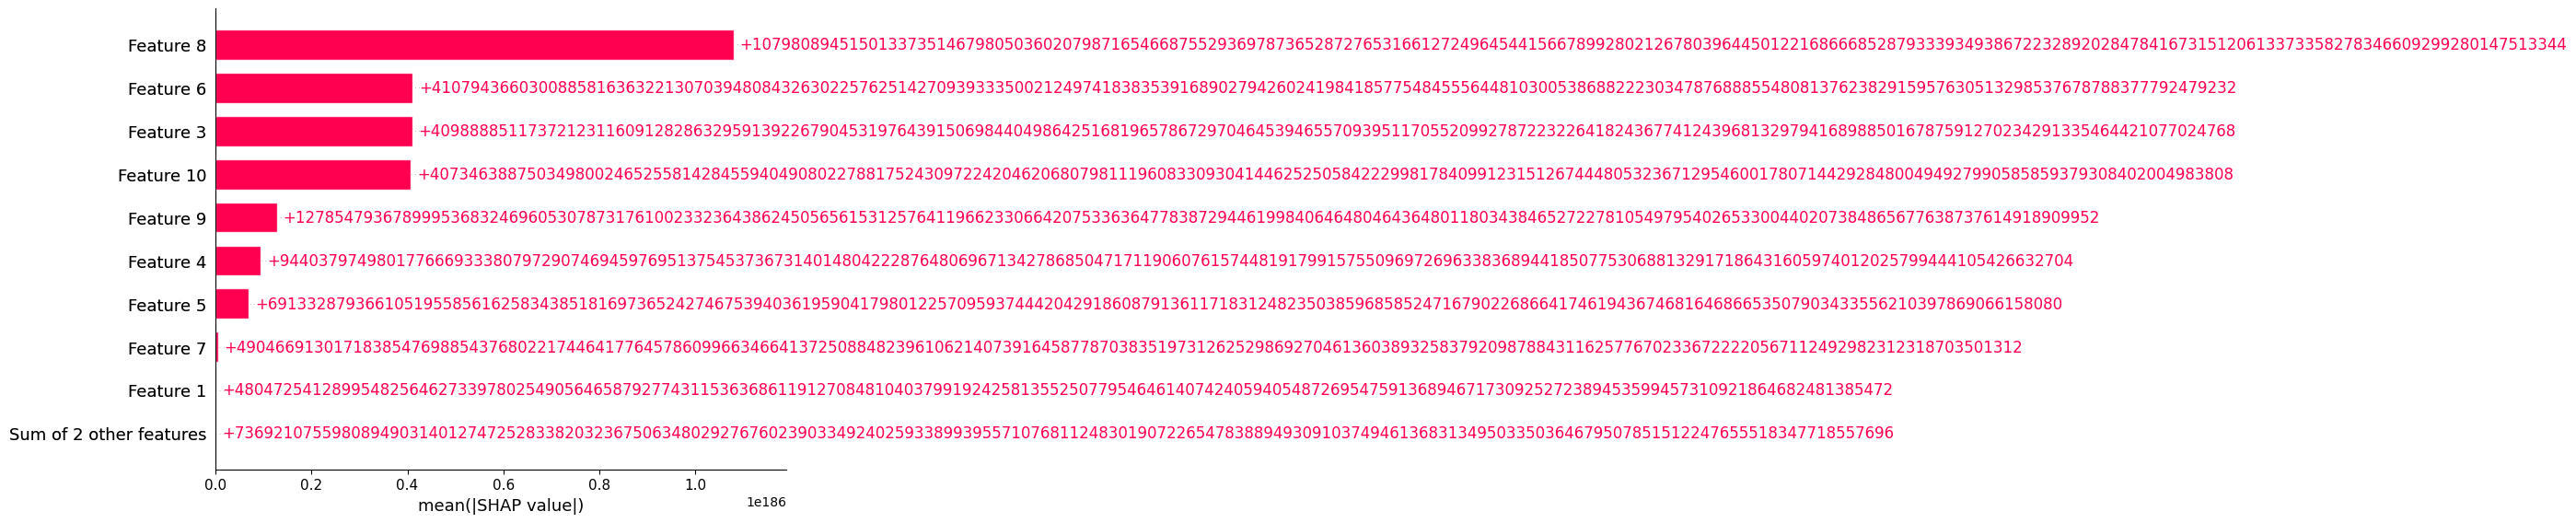

In [10]:
shap.plots.bar(shap_values2)
